## Load libraries

In [1]:
# base tools
import os, sys
sys.path.append(os.path.join(".."))

# data analysis
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

# tensorflow
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# style utils 
from utils.styletransfer import *

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline     

## Helper functions

In [ ]:
def extract_features(img_path, model):
    """
    Extract features from image data using pretrained model (e.g. VGG16)
    """
    # Define input image shape - remember we need to reshape
    input_shape = (224, 224, 3)
    # load image from file path
    img = load_img(img_path, target_size=(input_shape[0], 
                                          input_shape[1]))
    # convert to array
    img_array = img_to_array(img)
    # expand to fit dimensions
    expanded_img_array = np.expand_dims(img_array, axis=0)
    # preprocess image - see last week's notebook
    preprocessed_img = preprocess_input(expanded_img_array)
    # use the predict function to create feature representation
    features = model.predict(preprocessed_img)
    # flatten
    flattened_features = features.flatten()
    # normalise features
    normalized_features = flattened_features / norm(features)
    return flattened_features

def get_file_list(root_dir):
    # define valid file extensions
    extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
    # create empty file list
    file_list = []
    # initialise counter
    counter = 1
    # use os.walk to create a list of image filepaths
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            # keep only those with valid extensions
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                # increment counter
                counter += 1
    return file_list

# Image search

## Load VGG16

In [ ]:
model = ResNet50(weights='imagenet', 
                  include_top=False,
                  pooling='avg',
                  input_shape=(224, 224, 3))

## Extract features from single image

In [ ]:
features = extract_features('../data/img/florence.jpg', model)

## Iterate over folder

In [ ]:
# path to the datasets
root_dir = '../data/jpg'
filenames = sorted(get_file_list(root_dir))

__Extract features for each image__

In [ ]:
feature_list = []
for i in tqdm(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

## Nearest neighbours

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10, 
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

__Calculate nearest neighbours for target__

In [ ]:
distances, indices = neighbors.kneighbors([feature_list[250]])

__Save indices, print data__

In [ ]:
idxs = []
for i in range(6):
    print(distances[0][i], indices[0][i])
    idxs.append(indices[0][i])

__Plot target image__

In [ ]:
plt.imshow(mpimg.imread(filenames[250]))

__Plot close images__

In [ ]:
plt.imshow(mpimg.imread(filenames[251]))

__Plot target and top 3 closest together__

In [ ]:
# plt target
plt.imshow(mpimg.imread(filenames[251]))

# plot 3 most similar
f, axarr = plt.subplots(1,3)
axarr[0].imshow(mpimg.imread(filenames[idxs[1]]))
axarr[1].imshow(mpimg.imread(filenames[idxs[2]]))
axarr[2].imshow(mpimg.imread(filenames[idxs[3]]))

# Style transfer

__Load a quick style transfer model from TF Hub__

You can find more details [here](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)

In [2]:
# Load TF-Hub module.
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

__Load the content image and the style image__

In [21]:
content_image = st_load("../data/img/florence.jpg")
style_image = st_load("../data/img/starry_night.jpg")

__Process using the model__

In [22]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

__Show content, style, and stylized image__

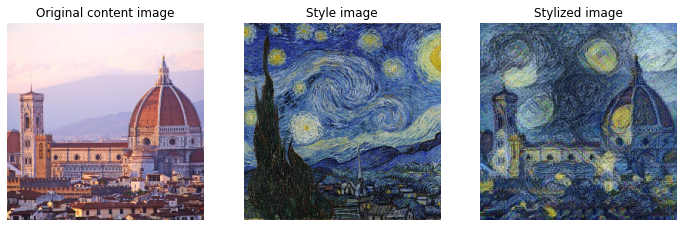

In [23]:
show_n([content_image, style_image, stylized_image], 
       titles=['Original content image', 'Style image', 'Stylized image'])